# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.369078
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Since there are 10 classes the probability of randomly guessing the correct class is 0.1 and that is what we would expect if we randomly initialize the weights.*


In [26]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.729799 analytic: -1.729799, relative error: 6.068224e-08
numerical: -0.733029 analytic: -0.733029, relative error: 9.076980e-08
numerical: -2.981267 analytic: -2.981267, relative error: 3.593139e-09
numerical: -0.064475 analytic: -0.064475, relative error: 3.868887e-07
numerical: 0.295914 analytic: 0.295914, relative error: 1.085915e-07
numerical: 0.393906 analytic: 0.393906, relative error: 1.480902e-07
numerical: -0.751775 analytic: -0.751776, relative error: 1.363017e-07
numerical: 0.975939 analytic: 0.975939, relative error: 7.023532e-09
numerical: 0.512904 analytic: 0.512904, relative error: 1.949043e-08
numerical: 0.280249 analytic: 0.280249, relative error: 7.054118e-08
numerical: 0.649556 analytic: 0.649556, relative error: 5.919668e-08
numerical: -1.680619 analytic: -1.680619, relative error: 5.281864e-09
numerical: -0.640812 analytic: -0.640812, relative error: 2.435711e-08
numerical: -1.318516 analytic: -1.318516, relative error: 6.976795e-08
numerical: -5.6885

numerical: 0.904234 analytic: 0.904234, relative error: 7.676441e-08
numerical: 0.923783 analytic: 0.923783, relative error: 6.780229e-08
numerical: 0.122042 analytic: 0.122042, relative error: 1.568341e-07
numerical: -0.681305 analytic: -0.681305, relative error: 4.089310e-08
numerical: 0.597450 analytic: 0.597450, relative error: 2.175954e-08
numerical: 0.335142 analytic: 0.335142, relative error: 1.521166e-07
numerical: -0.449182 analytic: -0.449182, relative error: 2.478933e-08
numerical: 3.706463 analytic: 3.706463, relative error: 1.450976e-08
numerical: -4.071447 analytic: -4.071447, relative error: 4.763510e-09
numerical: 0.783007 analytic: 0.783007, relative error: 5.308478e-10
numerical: -1.139713 analytic: -1.139713, relative error: 3.838565e-09
numerical: -1.277489 analytic: -1.277489, relative error: 1.550079e-08
numerical: 2.365953 analytic: 2.365953, relative error: 1.406651e-08
numerical: -1.269312 analytic: -1.269312, relative error: 3.872686e-08
numerical: 2.163295 an

In [84]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.369078e+00 computed in 0.113781s
vectorized loss: 2.369078e+00 computed in 0.004438s
Loss difference: 0.000000
Gradient difference: 0.000000


In [96]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-8, 1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e2, 1e3, 5e3, 1e4, 2.5e4, 5e4, 1e5, 2.5e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        softmax = Softmax()
        print ('lr %e reg %e' % (learning_rate, regularization_strength))
        softmax.train(X_train, y_train, learning_rate, regularization_strength, num_iters=5500,
                       batch_size=200, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, regularization_strength)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-08 reg 5.000000e+02
iteration 0 / 5500: loss 21.799008
iteration 100 / 5500: loss 20.321793
iteration 200 / 5500: loss 19.074057
iteration 300 / 5500: loss 18.647829
iteration 400 / 5500: loss 18.412395
iteration 500 / 5500: loss 18.158774
iteration 600 / 5500: loss 17.831536
iteration 700 / 5500: loss 17.481582
iteration 800 / 5500: loss 17.422148
iteration 900 / 5500: loss 17.190031
iteration 1000 / 5500: loss 16.887033
iteration 1100 / 5500: loss 16.601889
iteration 1200 / 5500: loss 16.669770
iteration 1300 / 5500: loss 16.456929
iteration 1400 / 5500: loss 16.106188
iteration 1500 / 5500: loss 15.842596
iteration 1600 / 5500: loss 15.812531
iteration 1700 / 5500: loss 15.422581
iteration 1800 / 5500: loss 15.379338
iteration 1900 / 5500: loss 15.176415
iteration 2000 / 5500: loss 15.141256
iteration 2100 / 5500: loss 15.079569
iteration 2200 / 5500: loss 14.845562
iteration 2300 / 5500: loss 14.469285
iteration 2400 / 5500: loss 14.358573
iteration 2500 / 5500: loss 1

iteration 5000 / 5500: loss 2.037053
iteration 5100 / 5500: loss 2.019390
iteration 5200 / 5500: loss 2.128438
iteration 5300 / 5500: loss 2.040638
iteration 5400 / 5500: loss 2.004338
lr 5.000000e-08 reg 2.500000e+04
iteration 0 / 5500: loss 778.552039
iteration 100 / 5500: loss 471.789815
iteration 200 / 5500: loss 286.131133
iteration 300 / 5500: loss 174.017378
iteration 400 / 5500: loss 106.143827
iteration 500 / 5500: loss 64.995299
iteration 600 / 5500: loss 40.160633
iteration 700 / 5500: loss 25.132303
iteration 800 / 5500: loss 16.036193
iteration 900 / 5500: loss 10.464697
iteration 1000 / 5500: loss 7.266627
iteration 1100 / 5500: loss 5.187893
iteration 1200 / 5500: loss 3.956010
iteration 1300 / 5500: loss 3.210539
iteration 1400 / 5500: loss 2.755768
iteration 1500 / 5500: loss 2.455254
iteration 1600 / 5500: loss 2.347772
iteration 1700 / 5500: loss 2.189413
iteration 1800 / 5500: loss 2.161550
iteration 1900 / 5500: loss 2.146761
iteration 2000 / 5500: loss 2.122761
it

iteration 4900 / 5500: loss 2.243931
iteration 5000 / 5500: loss 2.246246
iteration 5100 / 5500: loss 2.256819
iteration 5200 / 5500: loss 2.233150
iteration 5300 / 5500: loss 2.232216
iteration 5400 / 5500: loss 2.240272
lr 1.000000e-07 reg 5.000000e+02
iteration 0 / 5500: loss 21.287525
iteration 100 / 5500: loss 19.592766
iteration 200 / 5500: loss 18.772222
iteration 300 / 5500: loss 18.076706
iteration 400 / 5500: loss 17.579624
iteration 500 / 5500: loss 16.876373
iteration 600 / 5500: loss 16.741388
iteration 700 / 5500: loss 16.269989
iteration 800 / 5500: loss 15.694070
iteration 900 / 5500: loss 15.529655
iteration 1000 / 5500: loss 15.202878
iteration 1100 / 5500: loss 14.701730
iteration 1200 / 5500: loss 14.704534
iteration 1300 / 5500: loss 14.385161
iteration 1400 / 5500: loss 13.728199
iteration 1500 / 5500: loss 13.806906
iteration 1600 / 5500: loss 13.440516
iteration 1700 / 5500: loss 13.125334
iteration 1800 / 5500: loss 12.948763
iteration 1900 / 5500: loss 12.6002

iteration 4600 / 5500: loss 2.058227
iteration 4700 / 5500: loss 2.016686
iteration 4800 / 5500: loss 2.046883
iteration 4900 / 5500: loss 2.029260
iteration 5000 / 5500: loss 1.937771
iteration 5100 / 5500: loss 2.074977
iteration 5200 / 5500: loss 1.936348
iteration 5300 / 5500: loss 1.920069
iteration 5400 / 5500: loss 2.046177
lr 1.000000e-07 reg 2.500000e+04
iteration 0 / 5500: loss 763.020191
iteration 100 / 5500: loss 279.773712
iteration 200 / 5500: loss 103.631457
iteration 300 / 5500: loss 39.302178
iteration 400 / 5500: loss 15.720967
iteration 500 / 5500: loss 7.005355
iteration 600 / 5500: loss 3.904799
iteration 700 / 5500: loss 2.803936
iteration 800 / 5500: loss 2.324657
iteration 900 / 5500: loss 2.160812
iteration 1000 / 5500: loss 2.062032
iteration 1100 / 5500: loss 2.131260
iteration 1200 / 5500: loss 2.046211
iteration 1300 / 5500: loss 2.107473
iteration 1400 / 5500: loss 2.069964
iteration 1500 / 5500: loss 2.083030
iteration 1600 / 5500: loss 2.066984
iteration

iteration 4500 / 5500: loss 2.248988
iteration 4600 / 5500: loss 2.220454
iteration 4700 / 5500: loss 2.246884
iteration 4800 / 5500: loss 2.267285
iteration 4900 / 5500: loss 2.232721
iteration 5000 / 5500: loss 2.236659
iteration 5100 / 5500: loss 2.225170
iteration 5200 / 5500: loss 2.237449
iteration 5300 / 5500: loss 2.253879
iteration 5400 / 5500: loss 2.240262
lr 5.000000e-07 reg 5.000000e+02
iteration 0 / 5500: loss 20.951044
iteration 100 / 5500: loss 16.832257
iteration 200 / 5500: loss 14.886079
iteration 300 / 5500: loss 13.528351
iteration 400 / 5500: loss 12.383899
iteration 500 / 5500: loss 11.246739
iteration 600 / 5500: loss 10.238914
iteration 700 / 5500: loss 9.518243
iteration 800 / 5500: loss 8.675876
iteration 900 / 5500: loss 7.962636
iteration 1000 / 5500: loss 7.288368
iteration 1100 / 5500: loss 6.857211
iteration 1200 / 5500: loss 6.246734
iteration 1300 / 5500: loss 5.931689
iteration 1400 / 5500: loss 5.490069
iteration 1500 / 5500: loss 5.085428
iteration 

iteration 4400 / 5500: loss 1.952167
iteration 4500 / 5500: loss 2.005313
iteration 4600 / 5500: loss 1.969110
iteration 4700 / 5500: loss 1.978949
iteration 4800 / 5500: loss 2.007038
iteration 4900 / 5500: loss 1.923840
iteration 5000 / 5500: loss 2.070780
iteration 5100 / 5500: loss 1.947405
iteration 5200 / 5500: loss 2.009103
iteration 5300 / 5500: loss 2.111229
iteration 5400 / 5500: loss 2.037369
lr 5.000000e-07 reg 2.500000e+04
iteration 0 / 5500: loss 779.196275
iteration 100 / 5500: loss 6.916910
iteration 200 / 5500: loss 2.034440
iteration 300 / 5500: loss 2.064260
iteration 400 / 5500: loss 2.077819
iteration 500 / 5500: loss 2.129044
iteration 600 / 5500: loss 2.091345
iteration 700 / 5500: loss 2.106638
iteration 800 / 5500: loss 2.133675
iteration 900 / 5500: loss 2.093156
iteration 1000 / 5500: loss 2.112155
iteration 1100 / 5500: loss 2.017979
iteration 1200 / 5500: loss 2.046052
iteration 1300 / 5500: loss 2.117830
iteration 1400 / 5500: loss 2.093842
iteration 1500 

iteration 4300 / 5500: loss 2.246098
iteration 4400 / 5500: loss 2.255299
iteration 4500 / 5500: loss 2.257567
iteration 4600 / 5500: loss 2.249124
iteration 4700 / 5500: loss 2.232807
iteration 4800 / 5500: loss 2.253751
iteration 4900 / 5500: loss 2.245365
iteration 5000 / 5500: loss 2.239384
iteration 5100 / 5500: loss 2.271646
iteration 5200 / 5500: loss 2.250397
iteration 5300 / 5500: loss 2.250519
iteration 5400 / 5500: loss 2.263854
lr 1.000000e-06 reg 5.000000e+02
iteration 0 / 5500: loss 20.454428
iteration 100 / 5500: loss 15.034371
iteration 200 / 5500: loss 12.467438
iteration 300 / 5500: loss 10.236298
iteration 400 / 5500: loss 8.581277
iteration 500 / 5500: loss 7.454831
iteration 600 / 5500: loss 6.209101
iteration 700 / 5500: loss 5.407174
iteration 800 / 5500: loss 4.748375
iteration 900 / 5500: loss 4.223606
iteration 1000 / 5500: loss 3.843300
iteration 1100 / 5500: loss 3.397698
iteration 1200 / 5500: loss 3.051915
iteration 1300 / 5500: loss 2.751834
iteration 140

iteration 4200 / 5500: loss 2.092547
iteration 4300 / 5500: loss 2.117050
iteration 4400 / 5500: loss 2.063844
iteration 4500 / 5500: loss 1.973818
iteration 4600 / 5500: loss 2.051567
iteration 4700 / 5500: loss 2.010606
iteration 4800 / 5500: loss 1.999421
iteration 4900 / 5500: loss 2.082164
iteration 5000 / 5500: loss 2.000839
iteration 5100 / 5500: loss 1.994336
iteration 5200 / 5500: loss 2.018139
iteration 5300 / 5500: loss 2.041213
iteration 5400 / 5500: loss 1.990109
lr 1.000000e-06 reg 2.500000e+04
iteration 0 / 5500: loss 791.086998
iteration 100 / 5500: loss 2.113140
iteration 200 / 5500: loss 2.135206
iteration 300 / 5500: loss 2.053621
iteration 400 / 5500: loss 2.109148
iteration 500 / 5500: loss 2.119821
iteration 600 / 5500: loss 2.074005
iteration 700 / 5500: loss 2.156502
iteration 800 / 5500: loss 2.048748
iteration 900 / 5500: loss 2.092030
iteration 1000 / 5500: loss 2.085502
iteration 1100 / 5500: loss 2.093870
iteration 1200 / 5500: loss 2.106695
iteration 1300 

iteration 4100 / 5500: loss 2.259663
iteration 4200 / 5500: loss 2.249006
iteration 4300 / 5500: loss 2.245388
iteration 4400 / 5500: loss 2.269993
iteration 4500 / 5500: loss 2.253620
iteration 4600 / 5500: loss 2.280331
iteration 4700 / 5500: loss 2.279011
iteration 4800 / 5500: loss 2.268921
iteration 4900 / 5500: loss 2.259666
iteration 5000 / 5500: loss 2.279037
iteration 5100 / 5500: loss 2.259308
iteration 5200 / 5500: loss 2.268356
iteration 5300 / 5500: loss 2.253805
iteration 5400 / 5500: loss 2.266330
lr 5.000000e-06 reg 5.000000e+02
iteration 0 / 5500: loss 20.258183
iteration 100 / 5500: loss 7.530748
iteration 200 / 5500: loss 3.813126
iteration 300 / 5500: loss 2.570840
iteration 400 / 5500: loss 2.116298
iteration 500 / 5500: loss 2.030181
iteration 600 / 5500: loss 1.952976
iteration 700 / 5500: loss 2.018075
iteration 800 / 5500: loss 2.023351
iteration 900 / 5500: loss 1.962775
iteration 1000 / 5500: loss 1.868773
iteration 1100 / 5500: loss 1.807756
iteration 1200 /

iteration 4000 / 5500: loss 2.357428
iteration 4100 / 5500: loss 2.120059
iteration 4200 / 5500: loss 2.355853
iteration 4300 / 5500: loss 2.216064
iteration 4400 / 5500: loss 2.462925
iteration 4500 / 5500: loss 2.308882
iteration 4600 / 5500: loss 2.203101
iteration 4700 / 5500: loss 2.180506
iteration 4800 / 5500: loss 2.082960
iteration 4900 / 5500: loss 2.122108
iteration 5000 / 5500: loss 2.084994
iteration 5100 / 5500: loss 2.090579
iteration 5200 / 5500: loss 2.425464
iteration 5300 / 5500: loss 2.094774
iteration 5400 / 5500: loss 2.130195
lr 5.000000e-06 reg 2.500000e+04
iteration 0 / 5500: loss 767.369864
iteration 100 / 5500: loss 2.664116
iteration 200 / 5500: loss 2.282791
iteration 300 / 5500: loss 3.724040
iteration 400 / 5500: loss 2.958273
iteration 500 / 5500: loss 3.175456
iteration 600 / 5500: loss 2.346292
iteration 700 / 5500: loss 2.204232
iteration 800 / 5500: loss 2.593049
iteration 900 / 5500: loss 2.517462
iteration 1000 / 5500: loss 2.921979
iteration 1100 

/home/dd/code/cs231n/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(loss)


iteration 100 / 5500: loss inf
iteration 200 / 5500: loss inf
iteration 300 / 5500: loss inf
iteration 400 / 5500: loss inf
iteration 500 / 5500: loss inf
iteration 600 / 5500: loss inf
iteration 700 / 5500: loss inf
iteration 800 / 5500: loss inf


/home/dd/code/cs231n/assignment1/cs231n/classifiers/softmax.py:101: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/dd/code/cs231n/assignment1/cs231n/classifiers/softmax.py:101: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 5500: loss inf
iteration 1000 / 5500: loss inf
iteration 1100 / 5500: loss inf
iteration 1200 / 5500: loss inf
iteration 1300 / 5500: loss inf
iteration 1400 / 5500: loss inf
iteration 1500 / 5500: loss inf
iteration 1600 / 5500: loss inf
iteration 1700 / 5500: loss inf


/home/dd/code/cs231n/assignment1/cs231n/classifiers/softmax.py:96: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/dd/code/cs231n/assignment1/cs231n/classifiers/softmax.py:89: RuntimeWarning: invalid value encountered in subtract
  S -= np.max(S, axis = 1).reshape((num_train, 1))


iteration 1800 / 5500: loss nan
iteration 1900 / 5500: loss nan
iteration 2000 / 5500: loss nan
iteration 2100 / 5500: loss nan
iteration 2200 / 5500: loss nan
iteration 2300 / 5500: loss nan
iteration 2400 / 5500: loss nan
iteration 2500 / 5500: loss nan
iteration 2600 / 5500: loss nan
iteration 2700 / 5500: loss nan
iteration 2800 / 5500: loss nan
iteration 2900 / 5500: loss nan
iteration 3000 / 5500: loss nan
iteration 3100 / 5500: loss nan
iteration 3200 / 5500: loss nan
iteration 3300 / 5500: loss nan
iteration 3400 / 5500: loss nan
iteration 3500 / 5500: loss nan
iteration 3600 / 5500: loss nan
iteration 3700 / 5500: loss nan
iteration 3800 / 5500: loss nan
iteration 3900 / 5500: loss nan
iteration 4000 / 5500: loss nan
iteration 4100 / 5500: loss nan
iteration 4200 / 5500: loss nan
iteration 4300 / 5500: loss nan
iteration 4400 / 5500: loss nan
iteration 4500 / 5500: loss nan
iteration 4600 / 5500: loss nan
iteration 4700 / 5500: loss nan
iteration 4800 / 5500: loss nan
iteratio

In [97]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.397000


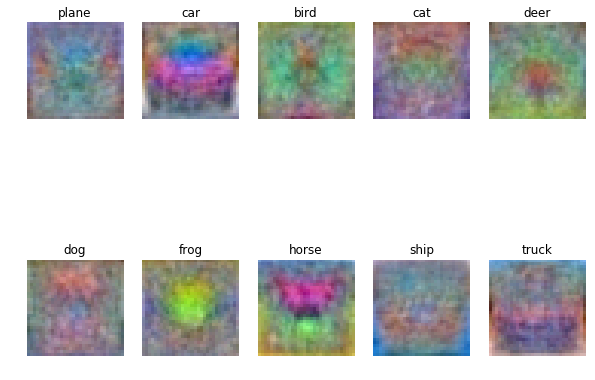

In [98]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])